## Imports and Setup

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


True
Tesla T4
Using device: cuda


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## Load Preprocessed Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
train_df = pd.read_csv('/content/drive/MyDrive/ML_dataset/train_clean.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ML_dataset/test_clean.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()


Mounted at /content/drive
Train shape: (40000, 5)
Test shape: (10000, 5)


,review,sentiment,clean_review,tokens,label
0,I caught this little gem totally by accident b...,positive,i caught this little gem totally by accident b...,"['i', 'caught', 'this', 'little', 'gem', 'tota...",1
1,I can't believe that I let myself into this mo...,negative,i cant believe that i let myself into this mov...,"['i', 'cant', 'believe', 'that', 'i', 'let', '...",0
2,*spoiler alert!* it just gets to me the nerve ...,negative,spoiler alert it just gets to me the nerve som...,"['spoiler', 'alert', 'it', 'just', 'gets', 'to...",0
3,If there's one thing I've learnt from watching...,negative,if theres one thing ive learnt from watching g...,"['if', 'theres', 'one', 'thing', 'ive', 'learn...",0
4,"I remember when this was in theaters, reviews ...",negative,i remember when this was in theaters reviews s...,"['i', 'remember', 'when', 'this', 'was', 'in',...",0


## Tokenization & Vocabulary

In [4]:
from collections import Counter
import ast  # To convert stringified lists back to Python lists

# Convert tokens back to list form
train_df["tokens"] = train_df["tokens"].apply(ast.literal_eval)
test_df["tokens"] = test_df["tokens"].apply(ast.literal_eval)

# Build vocabulary from training data
counter = Counter([token for tokens in train_df["tokens"] for token in tokens])
vocab_size = 10000  # top 10k words
most_common = counter.most_common(vocab_size - 2)  # reserve 2 for PAD, UNK

# Assign IDs
word2idx = {"<PAD>": 0, "<UNK>": 1}
for i, (word, _) in enumerate(most_common, start=2):
    word2idx[word] = i

print("Vocab size (including special tokens):", len(word2idx))


Vocab size (including special tokens): 10000


## Convert Tokens to Numeric Sequences

In [5]:
max_len = 500

def encode_tokens_and_get_length(tokens, word2idx, max_len):
    # Get original length before padding/truncating
    length = len(tokens)

    encoded = [word2idx.get(token, word2idx["<UNK>"]) for token in tokens]

    if len(encoded) < max_len:
        # Pad
        encoded += [word2idx["<PAD>"]] * (max_len - len(encoded))
    else:
        # Truncate
        encoded = encoded[:max_len]
        length = max_len # Cap length at max_len

    return encoded, length # Return both

# Apply this to get two new columns
print("Encoding training data...")
encoded_data_train = train_df["tokens"].apply(lambda x: encode_tokens_and_get_length(x, word2idx, max_len))
train_df["encoded"] = encoded_data_train.apply(lambda x: x[0])
train_df["length"] = encoded_data_train.apply(lambda x: x[1])

print("Encoding test data...")
encoded_data_test = test_df["tokens"].apply(lambda x: encode_tokens_and_get_length(x, word2idx, max_len))
test_df["encoded"] = encoded_data_test.apply(lambda x: x[0])
test_df["length"] = encoded_data_test.apply(lambda x: x[1])

print("\nExample of encoded data:")
print(train_df[["tokens", "encoded", "length"]].head(1))

Encoding training data...
Encoding test data...

Example of encoded data:
                                              tokens  \
0  [i, caught, this, little, gem, totally, by, ac...   

                                             encoded  length  
0  [10, 1019, 11, 116, 1480, 438, 32, 1614, 142, ...     162  


## Create PyTorch Dataset & Dataloader

In [6]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Split the 40k training data into train (36k) and validation (4k)
train_df_main, val_df = train_test_split(
    train_df,
    test_size=0.1,
    random_state=42,
    stratify=train_df['label']
)

class IMDbDataset(Dataset):
    def __init__(self, df):
        self.data = df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        x = torch.tensor(row["encoded"], dtype=torch.long)
        y = torch.tensor(row["label"], dtype=torch.long)
        # --- NEW: Return the sequence length ---
        length = torch.tensor(row["length"], dtype=torch.long)
        return x, y, length # Return all three

# Create all three datasets
train_dataset = IMDbDataset(train_df_main)
val_dataset = IMDbDataset(val_df)
test_dataset = IMDbDataset(test_df) # This is the original 10k test set

# Create all three dataloaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 36000
Validation samples: 4000
Test samples: 10000


## Define LSTM Model

In [7]:
from torch.nn.utils.rnn import pack_padded_sequence

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim=256, num_classes=2):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # --- CHANGES ---
        # 1. Added bidirectional=True (much more powerful)
        # 2. Kept num_layers=1 for simplicity
        self.lstm = nn.LSTM(embed_dim,
                            hidden_dim,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True) # ---

        # 3. FC layer now takes hidden_dim * 2 (for bidirectional)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(0.3)
        # --- END CHANGES ---

    # --- CHANGE: Forward now accepts lengths ---
    def forward(self, x, lengths):
        # x shape: (batch_size, seq_len)

        x = self.embedding(x)
        # x shape: (batch_size, seq_len, embed_dim)

        # --- NEW: Pack the sequence ---
        # This tells the LSTM to ignore padding
        # lengths must be on CPU
        x_packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # h shape: (num_layers * num_directions, batch_size, hidden_dim) -> (2, 64, 256)
        packed_out, (h, c) = self.lstm(x_packed)

        # --- NEW: Concatenate final forward (h[0]) and backward (h[1]) hidden states ---
        # h shape is (2, 64, 256). We permute to (64, 2, 256)
        h = h.permute(1, 0, 2)
        # Then flatten to (64, 512)
        h = h.contiguous().view(h.size(0), -1)

        out = self.dropout(h)
        out = self.fc(out)
        return out

## Training & Evaluation Function

In [8]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
import time

def train_model(embed_dim, train_loader, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = LSTMClassifier(vocab_size=len(word2idx), embed_dim=embed_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3) # 1e-3 is a good default

    num_epochs = 5

    train_losses, val_losses, val_accuracies = [], [], []
    best_val_acc = 0
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        # --- CHANGE: Unpack lengths ---
        for X, y, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training"):
            # Move X and y to GPU, lengths must stay on CPU for pack_padded_sequence
            X, y = X.to(device), y.to(device)
            lengths = lengths.to('cpu')

            optimizer.zero_grad()

            # --- CHANGE: Pass lengths to model ---
            out = model(X, lengths)
            loss = criterion(out, y)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        # --- Validation Loop ---
        model.eval()
        val_preds, val_true = [], []
        total_val_loss = 0
        with torch.no_grad():
            # --- CHANGE: Unpack lengths ---
            for X, y, lengths in val_loader:
                X, y = X.to(device), y.to(device)
                lengths = lengths.to('cpu')

                # --- CHANGE: Pass lengths to model ---
                out = model(X, lengths)
                val_loss = criterion(out, y)
                total_val_loss += val_loss.item()

                pred = torch.argmax(out, dim=1)
                val_preds.extend(pred.cpu().tolist())
                val_true.extend(y.cpu().tolist())

        val_acc = accuracy_score(val_true, val_preds)
        val_accuracies.append(val_acc)
        val_losses.append(total_val_loss / len(val_loader))

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}, Val Acc={val_acc:.4f}")

    # --- Calculate Final Train Accuracy for Overfitting Gap ---
    model.eval()
    train_preds, train_true = [], []
    with torch.no_grad():
        for X, y, lengths in train_loader:
            X, y = X.to(device), y.to(device)
            lengths = lengths.to('cpu')
            out = model(X, lengths)
            pred = torch.argmax(out, dim=1)
            train_preds.extend(pred.cpu().tolist())
            train_true.extend(y.cpu().tolist())

    final_train_acc = accuracy_score(train_true, train_preds)
    overfitting_gap = final_train_acc - best_val_acc

    duration = time.time() - start_time
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    return {
        "embedding_dim": embed_dim,
        "best_val_acc": best_val_acc,
        "final_train_acc": final_train_acc,
        "overfitting_gap": overfitting_gap,
        "train_time": duration,
        "params": total_params
    }

## Run Experiments for Different Embedding Sizes

In [9]:
results = []
embed_dims = [1,2,4,8, 16, 32, 64, 128, 256,512,1024,2048]

for dim in embed_dims:
    print(f"\n=== Training with embedding dimension: {dim} ===\n")
    # Pass both train_loader and val_loader
    result = train_model(dim, train_loader, val_loader)
    results.append(result)

df_results = pd.DataFrame(results)
print(df_results)


=== Training with embedding dimension: 1 ===

Using device: cuda


Epoch 1/5 Training: 100%|██████████| 563/563 [00:26<00:00, 20.92it/s]


Epoch 1: Train Loss=0.6925, Val Loss=0.6910, Val Acc=0.5280


Epoch 2/5 Training: 100%|██████████| 563/563 [00:26<00:00, 20.91it/s]


Epoch 2: Train Loss=0.6891, Val Loss=0.6878, Val Acc=0.5320


Epoch 3/5 Training: 100%|██████████| 563/563 [00:26<00:00, 21.37it/s]


Epoch 3: Train Loss=0.6833, Val Loss=0.7104, Val Acc=0.5060


Epoch 4/5 Training: 100%|██████████| 563/563 [00:26<00:00, 21.44it/s]


Epoch 4: Train Loss=0.6747, Val Loss=0.6686, Val Acc=0.5895


Epoch 5/5 Training: 100%|██████████| 563/563 [00:26<00:00, 21.59it/s]


Epoch 5: Train Loss=0.6621, Val Loss=0.6610, Val Acc=0.6025

=== Training with embedding dimension: 2 ===

Using device: cuda


Epoch 1/5 Training: 100%|██████████| 563/563 [00:26<00:00, 21.14it/s]


Epoch 1: Train Loss=0.6992, Val Loss=0.6926, Val Acc=0.5162


Epoch 2/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.84it/s]


Epoch 2: Train Loss=0.6991, Val Loss=0.6927, Val Acc=0.5022


Epoch 3/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.70it/s]


Epoch 3: Train Loss=0.6941, Val Loss=0.6870, Val Acc=0.5470


Epoch 4/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.62it/s]


Epoch 4: Train Loss=0.6744, Val Loss=0.6486, Val Acc=0.6210


Epoch 5/5 Training: 100%|██████████| 563/563 [00:28<00:00, 19.72it/s]


Epoch 5: Train Loss=0.6291, Val Loss=0.5782, Val Acc=0.7053

=== Training with embedding dimension: 4 ===

Using device: cuda


Epoch 1/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.65it/s]


Epoch 1: Train Loss=0.6899, Val Loss=0.6841, Val Acc=0.5525


Epoch 2/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.26it/s]


Epoch 2: Train Loss=0.6727, Val Loss=0.6545, Val Acc=0.6182


Epoch 3/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.60it/s]


Epoch 3: Train Loss=0.6541, Val Loss=0.6308, Val Acc=0.6368


Epoch 4/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.30it/s]


Epoch 4: Train Loss=0.6001, Val Loss=0.6064, Val Acc=0.6693


Epoch 5/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.44it/s]


Epoch 5: Train Loss=0.5434, Val Loss=0.4779, Val Acc=0.7752

=== Training with embedding dimension: 8 ===

Using device: cuda


Epoch 1/5 Training: 100%|██████████| 563/563 [00:28<00:00, 19.51it/s]


Epoch 1: Train Loss=0.6769, Val Loss=0.6620, Val Acc=0.6040


Epoch 2/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.39it/s]


Epoch 2: Train Loss=0.6256, Val Loss=0.6022, Val Acc=0.6737


Epoch 3/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.52it/s]


Epoch 3: Train Loss=0.5701, Val Loss=0.5530, Val Acc=0.7183


Epoch 4/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.61it/s]


Epoch 4: Train Loss=0.5605, Val Loss=0.5339, Val Acc=0.7378


Epoch 5/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.41it/s]


Epoch 5: Train Loss=0.4735, Val Loss=0.3984, Val Acc=0.8193

=== Training with embedding dimension: 16 ===

Using device: cuda


Epoch 1/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.16it/s]


Epoch 1: Train Loss=0.6677, Val Loss=0.6495, Val Acc=0.6108


Epoch 2/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.29it/s]


Epoch 2: Train Loss=0.5763, Val Loss=0.5288, Val Acc=0.7350


Epoch 3/5 Training: 100%|██████████| 563/563 [00:28<00:00, 19.52it/s]


Epoch 3: Train Loss=0.5576, Val Loss=0.5574, Val Acc=0.7285


Epoch 4/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.36it/s]


Epoch 4: Train Loss=0.5113, Val Loss=0.4300, Val Acc=0.8040


Epoch 5/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.53it/s]


Epoch 5: Train Loss=0.4532, Val Loss=0.4185, Val Acc=0.8170

=== Training with embedding dimension: 32 ===

Using device: cuda


Epoch 1/5 Training: 100%|██████████| 563/563 [00:28<00:00, 19.97it/s]


Epoch 1: Train Loss=0.6443, Val Loss=0.6230, Val Acc=0.6472


Epoch 2/5 Training: 100%|██████████| 563/563 [00:28<00:00, 19.85it/s]


Epoch 2: Train Loss=0.5313, Val Loss=0.4128, Val Acc=0.8207


Epoch 3/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.37it/s]


Epoch 3: Train Loss=0.3518, Val Loss=0.3321, Val Acc=0.8575


Epoch 4/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.48it/s]


Epoch 4: Train Loss=0.2867, Val Loss=0.3205, Val Acc=0.8750


Epoch 5/5 Training: 100%|██████████| 563/563 [00:28<00:00, 19.86it/s]


Epoch 5: Train Loss=0.2432, Val Loss=0.2917, Val Acc=0.8720

=== Training with embedding dimension: 64 ===

Using device: cuda


Epoch 1/5 Training: 100%|██████████| 563/563 [00:28<00:00, 19.68it/s]


Epoch 1: Train Loss=0.5939, Val Loss=0.7108, Val Acc=0.6120


Epoch 2/5 Training: 100%|██████████| 563/563 [00:28<00:00, 20.06it/s]


Epoch 2: Train Loss=0.4885, Val Loss=0.5970, Val Acc=0.6222


Epoch 3/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.36it/s]


Epoch 3: Train Loss=0.3657, Val Loss=0.3294, Val Acc=0.8632


Epoch 4/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.39it/s]


Epoch 4: Train Loss=0.2655, Val Loss=0.3036, Val Acc=0.8735


Epoch 5/5 Training: 100%|██████████| 563/563 [00:27<00:00, 20.14it/s]


Epoch 5: Train Loss=0.2182, Val Loss=0.2970, Val Acc=0.8888

=== Training with embedding dimension: 128 ===

Using device: cuda


Epoch 1/5 Training: 100%|██████████| 563/563 [00:29<00:00, 19.21it/s]


Epoch 1: Train Loss=0.6003, Val Loss=0.5724, Val Acc=0.6977


Epoch 2/5 Training: 100%|██████████| 563/563 [00:30<00:00, 18.69it/s]


Epoch 2: Train Loss=0.4301, Val Loss=0.3881, Val Acc=0.8283


Epoch 3/5 Training: 100%|██████████| 563/563 [00:28<00:00, 19.46it/s]


Epoch 3: Train Loss=0.2828, Val Loss=0.3034, Val Acc=0.8728


Epoch 4/5 Training: 100%|██████████| 563/563 [00:29<00:00, 19.13it/s]


Epoch 4: Train Loss=0.2060, Val Loss=0.3117, Val Acc=0.8815


Epoch 5/5 Training: 100%|██████████| 563/563 [00:29<00:00, 19.29it/s]


Epoch 5: Train Loss=0.1476, Val Loss=0.3232, Val Acc=0.8865

=== Training with embedding dimension: 256 ===

Using device: cuda


Epoch 1/5 Training: 100%|██████████| 563/563 [00:32<00:00, 17.28it/s]


Epoch 1: Train Loss=0.5572, Val Loss=0.4066, Val Acc=0.8195


Epoch 2/5 Training: 100%|██████████| 563/563 [00:32<00:00, 17.50it/s]


Epoch 2: Train Loss=0.3066, Val Loss=0.3003, Val Acc=0.8740


Epoch 3/5 Training: 100%|██████████| 563/563 [00:33<00:00, 17.00it/s]


Epoch 3: Train Loss=0.1952, Val Loss=0.3365, Val Acc=0.8620


Epoch 4/5 Training: 100%|██████████| 563/563 [00:32<00:00, 17.47it/s]


Epoch 4: Train Loss=0.1176, Val Loss=0.3323, Val Acc=0.8800


Epoch 5/5 Training: 100%|██████████| 563/563 [00:32<00:00, 17.31it/s]


Epoch 5: Train Loss=0.0561, Val Loss=0.4059, Val Acc=0.8740

=== Training with embedding dimension: 512 ===

Using device: cuda


Epoch 1/5 Training: 100%|██████████| 563/563 [00:38<00:00, 14.49it/s]


Epoch 1: Train Loss=0.4943, Val Loss=0.3230, Val Acc=0.8638


Epoch 2/5 Training: 100%|██████████| 563/563 [00:38<00:00, 14.47it/s]


Epoch 2: Train Loss=0.2461, Val Loss=0.2723, Val Acc=0.8855


Epoch 3/5 Training: 100%|██████████| 563/563 [00:39<00:00, 14.40it/s]


Epoch 3: Train Loss=0.1436, Val Loss=0.2959, Val Acc=0.8882


Epoch 4/5 Training: 100%|██████████| 563/563 [00:39<00:00, 14.39it/s]


Epoch 4: Train Loss=0.0645, Val Loss=0.3749, Val Acc=0.8940


Epoch 5/5 Training: 100%|██████████| 563/563 [00:38<00:00, 14.45it/s]


Epoch 5: Train Loss=0.0297, Val Loss=0.4675, Val Acc=0.8862

=== Training with embedding dimension: 1024 ===

Using device: cuda


Epoch 1/5 Training: 100%|██████████| 563/563 [00:54<00:00, 10.39it/s]


Epoch 1: Train Loss=0.5324, Val Loss=0.4173, Val Acc=0.8037


Epoch 2/5 Training: 100%|██████████| 563/563 [00:54<00:00, 10.35it/s]


Epoch 2: Train Loss=0.2921, Val Loss=0.3489, Val Acc=0.8538


Epoch 3/5 Training: 100%|██████████| 563/563 [00:54<00:00, 10.33it/s]


Epoch 3: Train Loss=0.1760, Val Loss=0.3483, Val Acc=0.8648


Epoch 4/5 Training: 100%|██████████| 563/563 [00:54<00:00, 10.33it/s]


Epoch 4: Train Loss=0.0890, Val Loss=0.4159, Val Acc=0.8700


Epoch 5/5 Training: 100%|██████████| 563/563 [00:54<00:00, 10.32it/s]


Epoch 5: Train Loss=0.0542, Val Loss=0.4535, Val Acc=0.8628

=== Training with embedding dimension: 2048 ===

Using device: cuda


Epoch 1/5 Training: 100%|██████████| 563/563 [01:27<00:00,  6.45it/s]


Epoch 1: Train Loss=0.5219, Val Loss=0.3938, Val Acc=0.8220


Epoch 2/5 Training: 100%|██████████| 563/563 [01:27<00:00,  6.41it/s]


Epoch 2: Train Loss=0.2992, Val Loss=0.3710, Val Acc=0.8365


Epoch 3/5 Training: 100%|██████████| 563/563 [01:27<00:00,  6.40it/s]


Epoch 3: Train Loss=0.1295, Val Loss=0.4249, Val Acc=0.8403


Epoch 4/5 Training: 100%|██████████| 563/563 [01:27<00:00,  6.40it/s]


Epoch 4: Train Loss=0.0501, Val Loss=0.5135, Val Acc=0.8385


Epoch 5/5 Training: 100%|██████████| 563/563 [01:27<00:00,  6.42it/s]


Epoch 5: Train Loss=0.0315, Val Loss=0.5821, Val Acc=0.8500
    embedding_dim  best_val_acc  final_train_acc  overfitting_gap  train_time  \
0               1       0.60250         0.623917         0.021417  151.965946   
1               2       0.70525         0.715583         0.010333  155.604359   
2               4       0.77525         0.791417         0.016167  157.156476   
3               8       0.81925         0.830917         0.011667  158.463505   
4              16       0.81700         0.841611         0.024611  159.053492   
5              32       0.87500         0.921333         0.046333  159.539175   
6              64       0.88875         0.940139         0.051389  159.684323   
7             128       0.88650         0.973667         0.087167  166.717609   
8             256       0.88000         0.994861         0.114861  183.984700   
9             512       0.89400         0.997306         0.103306  219.194862   
10           1024       0.87000         0.996056 

## Visualize Results

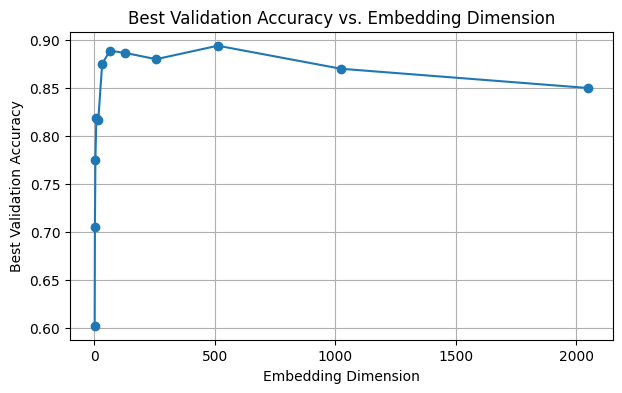

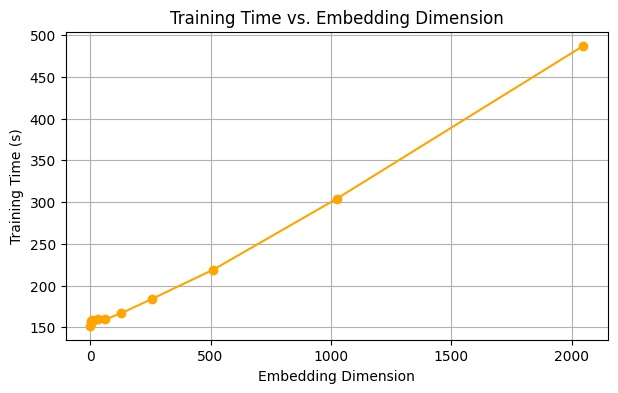

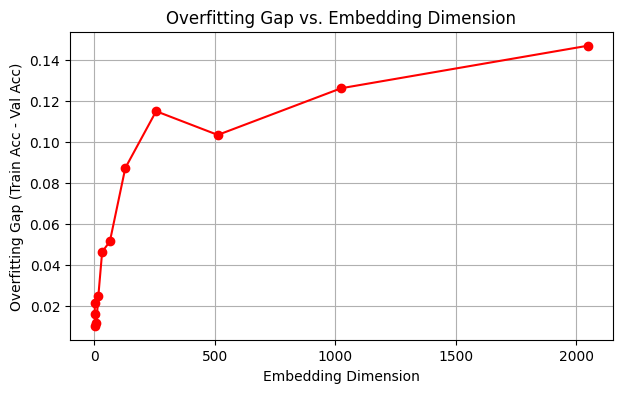

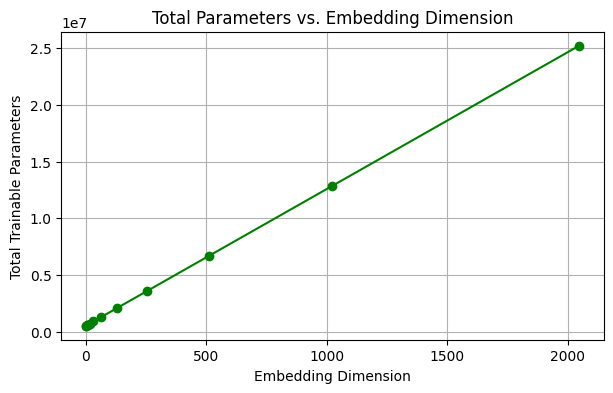

In [10]:
import matplotlib.pyplot as plt

# --- Plot 1: Accuracy vs. Dimension ---
plt.figure(figsize=(7,4))
plt.plot(df_results["embedding_dim"], df_results["best_val_acc"], marker="o")
plt.title("Best Validation Accuracy vs. Embedding Dimension")
plt.xlabel("Embedding Dimension")
plt.ylabel("Best Validation Accuracy")
plt.grid(True)
plt.show()

# --- Plot 2: Training Time vs. Dimension ---
plt.figure(figsize=(7,4))
plt.plot(df_results["embedding_dim"], df_results["train_time"], marker="o", color="orange")
plt.title("Training Time vs. Embedding Dimension")
plt.xlabel("Embedding Dimension")
plt.ylabel("Training Time (s)")
plt.grid(True)
plt.show()

# --- Plot 3: Overfitting Gap vs. Dimension ---
plt.figure(figsize=(7,4))
plt.plot(df_results["embedding_dim"], df_results["overfitting_gap"], marker="o", color="red")
plt.title("Overfitting Gap vs. Embedding Dimension")
plt.xlabel("Embedding Dimension")
plt.ylabel("Overfitting Gap (Train Acc - Val Acc)")
plt.grid(True)
plt.show()

# --- Plot 4: Parameters vs. Dimension ---
plt.figure(figsize=(7,4))
plt.plot(df_results["embedding_dim"], df_results["params"], marker="o", color="green")
plt.title("Total Parameters vs. Embedding Dimension")
plt.xlabel("Embedding Dimension")
plt.ylabel("Total Trainable Parameters")
plt.grid(True)
plt.show()

## Testing

In [11]:
# 1. Analyze df_results to find the best embedding dimension
# (We sort by 'best_val_acc' and get the 'embedding_dim' of the top-performing model)
best_dim_row = df_results.loc[df_results['best_val_acc'].idxmax()]
best_embed_dim = int(best_dim_row['embedding_dim'])

print(f"--- Analysis Complete ---")
print(f"Best performing dimension: {best_embed_dim} (Val Acc: {best_dim_row['best_val_acc']:.4f})")
print(f"Overfitting Gap for this model: {best_dim_row['overfitting_gap']:.4f}\n")


# 2. Define a function to evaluate the final, chosen model on the test_loader
def evaluate_on_test_set(embed_dim):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"--- Final Test ---")
    print(f"Training final model with embed_dim={embed_dim}...")

    # Re-initialize the best model
    model = LSTMClassifier(vocab_size=len(word2idx), embed_dim=embed_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 5 # Train it for the same 5 epochs

    # Train on the full 36k training set
    for epoch in range(num_epochs):
        model.train()
        for X, y, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Final Training"):
            X, y, lengths = X.to(device), y.to(device), lengths.to('cpu')
            optimizer.zero_grad()
            out = model(X, lengths)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

    print("Final training complete. Evaluating on the 10k test set...")

    # --- Final Evaluation on Test Loader ---
    model.eval()
    test_preds, test_true = [], []
    with torch.no_grad():
        for X, y, lengths in tqdm(test_loader, desc="Final Testing"):
            X, y, lengths = X.to(device), y.to(device), lengths.to('cpu')
            out = model(X, lengths)
            pred = torch.argmax(out, dim=1)
            test_preds.extend(pred.cpu().tolist())
            test_true.extend(y.cpu().tolist())

    final_test_acc = accuracy_score(test_true, test_preds)
    print(f"\n--- Project Result ---")
    print(f"Final Test Accuracy for embed_dim={best_embed_dim}: {final_test_acc:.4f}")

    return final_test_acc

# 3. Run the final test
final_accuracy = evaluate_on_test_set(best_embed_dim)

--- Analysis Complete ---
Best performing dimension: 512 (Val Acc: 0.8940)
Overfitting Gap for this model: 0.1033

--- Final Test ---
Training final model with embed_dim=512...


Epoch 5/5 Final Training: 100%|██████████| 563/563 [00:35<00:00, 15.96it/s]


Final training complete. Evaluating on the 10k test set...


Final Testing: 100%|██████████| 157/157 [00:04<00:00, 33.17it/s]


--- Project Result ---
Final Test Accuracy for embed_dim=512: 0.8710
